# CNN Factorio AI

In [1]:
import torch

print(torch.version.cuda)
# Check if CUDA GPU is available
if torch.cuda.is_available():
    print("CUDA is available. Training on GPU.")
else:
    print("CUDA not available. Training on CPU.")


None
CUDA not available. Training on CPU.


### Data processing

In [90]:
import numpy as np

import game
import importlib

importlib.reload(game)

from game import Board

import json
from tqdm import tqdm

#map_sym_int = json.load(open("sample.json", "r"))


def count_lines(filename):
    with open(filename, "rb") as f:  # binary mode for speed
        return sum(1 for _ in f)

filename = "game.txt"
total_lines = count_lines(filename)

# Parse the data
def parse_data(file):
    inputs = []
    outputs = []
    b = Board()

    index_board = ""
    with open(file,"r") as f:
        for line in tqdm(f, total=total_lines, desc="Parsing data"):
            if line == "\n":
                line = line.strip()
                #grid_array = str_to_array(index_board)
                grid_array = index_board.strip().split("\n")
                b.board_from_index(grid_array)
                r = b.total_reward()
                inputs.append(grid_array)
                outputs.append(float(r))
                b.board = b.reset()
                index_board = ""
            else:
                index_board += line
    return np.array(inputs), np.array(outputs).reshape(-1,1)

X, y = parse_data(filename)
print(X.shape, y.shape)
print(max(y), min(y))

Parsing data: 100%|██████████| 1800000/1800000 [00:14<00:00, 122195.66it/s]


(300000, 5) (300000, 1)
[3.6] [-6.36]


In [91]:
importlib.reload(game)
from game import Board

idx_x = np.where(y == max(y))[0][0]
b = Board()
b.board_from_index(X[idx_x])
print(idx_x)
print(b)
print(b.total_reward())

45438
Vo B< S^ T^ Co 
M^ T^ Co Co Vo 
B^ M^ Vo M< M^ 
M^ Co T^ Vo S< 
Vo S> T< B< Co 

3.6


In [86]:
print(len(y[y > 0.0]), len(y[y < -2.0]))

977 34782


(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2000e+01, 1.6000e+01,
        1.5000e+01, 1.4000e+01, 2.0000e+00, 0.0000e+00, 1.0000e+00,
        4.0000e+00, 3.0000e+00, 6.0000e+00, 4.0000e+00, 3.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 2.3000e+01, 5.5000e+01,
        9.7000e+01, 1.6300e+02, 5.1000e+01, 1.2000e+01, 2.0000e+00,
        2.0000e+00, 1.1000e+01, 2.1000e+01, 4.1000e+01, 3.2000e+01,
        6.0000e+00, 0.0000e+00, 4.0000e+00, 6.0000e+01, 2.8100e+02,
        5.4000e+02, 7.8600e+02, 8.7300e+02, 3.2500e+02, 8.3000e+01,
        1.5000e+01, 4.4000e+01, 1.2200e+02, 2.5600e+02, 1.5700e+02,
        8.1000e+01, 3.3000e+01, 1.1000e+01, 1.47

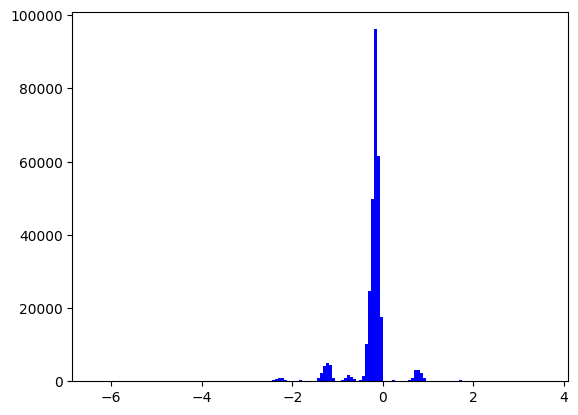

In [92]:
import matplotlib.pyplot as plt

plt.hist(y, bins=150, color='blue')

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from var import CELL_NUMBER

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_flat = X.reshape((X.shape[0], -1))

X_train , X_test, y_train,y_test = train_test_split(X_flat, y,test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

X_train_scaled = scaler_X.fit_transform(X_train).reshape(-1, CELL_NUMBER, CELL_NUMBER)
y_train_scaled = scaler_y.fit_transform(y_train)

X_test_scaled = scaler_X.transform(X_test).reshape(-1, CELL_NUMBER, CELL_NUMBER)
y_test_scaled = scaler_y.transform(y_test)

(80000, 25) (80000, 1) (20000, 25) (20000, 1)


In [19]:
from torch.utils.data import Dataset, DataLoader

class GridRewardDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # shape: (N, 1, 5, 5)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# DataLoader
ds_train = GridRewardDataset(X_train_scaled, y_train_scaled)
ds_test = GridRewardDataset(X_test_scaled, y_test_scaled)

train = DataLoader(ds_train, batch_size=32, shuffle=True,num_workers=27)
test = DataLoader(ds_test, batch_size=32,num_workers=27)

c:\Users\matth\miniconda3\envs\bird_clean\lib\site-packages\torch\utils\data\dataloader.py:617: UserWarning: This DataLoader will create 27 worker processes in total. Our suggested max number of worker in current system is 16 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### Lightning Module

In [25]:
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint


#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
#os.environ['CUDA_LAUNCH_BLOCKING']='1'

class RewardCNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),   # (B, 32, 5, 5)
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 64, kernel_size=3, padding=1),  # (B, 64, 5, 5)
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.AvgPool2d(kernel_size=2),                 # (B, 64, 2, 2)
    nn.Dropout(0.25),
    nn.Flatten(),                                # (B, 64*2*2)
    nn.Linear(64 * 2 * 2, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
        )
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss,on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.loss_fn(preds, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",          # metric to monitor
    mode="min",                  # minimize val_loss
    save_top_k=1,                # save only the best
    filename="best-checkpoint", # optional name
    verbose=True
)


early_stop_callback = EarlyStopping(
    monitor="val_loss",         # What to monitor
    patience=5,                 # Stop after 3 epochs without improvement
    verbose=True,
    mode="min"                  # Minimize the loss
)

model = RewardCNN()
trainer = pl.Trainer(max_epochs=100, callbacks=[checkpoint_callback,early_stop_callback],log_every_n_steps=1)
trainer.fit(model, train,test)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 52.0 K | train
1 | loss_fn | MSELoss    | 0      | train
-----------------------------------------------
52.0 K    Trainable params
0         Non-trainable params
52.0 K    Total params
0.208     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 2500/2500 [00:28<00:00, 87.65it/s, v_num=10, val_loss=0.0185, train_loss=0.0189]

Metric val_loss improved. New best score: 0.019
Epoch 0, global step 2500: 'val_loss' reached 0.01854 (best 0.01854), saving model to '/home/matthieu/Documents/FactorioAI/CNN/lightning_logs/version_10/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 1: 100%|██████████| 2500/2500 [00:28<00:00, 87.64it/s, v_num=10, val_loss=0.0181, train_loss=0.0181] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.018
Epoch 1, global step 5000: 'val_loss' reached 0.01806 (best 0.01806), saving model to '/home/matthieu/Documents/FactorioAI/CNN/lightning_logs/version_10/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 2:  30%|██▉       | 749/2500 [00:08<00:19, 90.37it/s, v_num=10, val_loss=0.0181, train_loss=0.0181] 


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [26]:
model.eval()
with torch.no_grad():
    for i, (x, y_true) in enumerate(test):
        y_pred = model(x)
        y_pred_denorm = scaler_y.inverse_transform(y_pred.cpu().numpy())
        y_true_denorm = scaler_y.inverse_transform(y_true.cpu().numpy())
        for yt, yp in zip(y_true_denorm, y_pred_denorm):
            print(f"True: {yt[0]:.2f}, Predicted: {yp[0]:.2f}")

True: 95.75, Predicted: 40.58
True: -5.50, Predicted: 30.72
True: 45.50, Predicted: 21.23
True: 44.75, Predicted: 22.11
True: 69.50, Predicted: 48.23
True: 144.50, Predicted: 44.22
True: -6.25, Predicted: 33.03
True: -5.25, Predicted: 19.86
True: -6.00, Predicted: 19.28
True: 162.17, Predicted: 43.19
True: 44.75, Predicted: 45.86
True: -6.00, Predicted: 56.95
True: -6.00, Predicted: 21.88
True: 70.00, Predicted: 36.34
True: 44.25, Predicted: 45.84
True: 194.00, Predicted: 53.88
True: -5.25, Predicted: 30.61
True: 44.00, Predicted: 30.40
True: -5.50, Predicted: 19.63
True: 45.50, Predicted: 22.99
True: -5.75, Predicted: 34.53
True: -5.75, Predicted: 30.63
True: -6.25, Predicted: 30.78
True: 95.00, Predicted: 28.11
True: 69.75, Predicted: 15.94
True: 44.50, Predicted: 25.46
True: -5.00, Predicted: 20.20
True: -5.50, Predicted: 29.82
True: -5.75, Predicted: 46.17
True: -5.75, Predicted: 21.30
True: 46.00, Predicted: 19.67
True: -6.25, Predicted: 43.24
True: 44.75, Predicted: 37.84
True: 9